In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import numpy as np


# Sketches for automating spatial models 
This notebook is for designing the tool box and methods for fitting spatial data.
I´m using the library Geopystats (before spystats)


## Requirements
* Given a dataset in Geopandas dataframe, create the Variogram object.
And read from the file the variogram data



In [2]:
from external_plugins.spystats import tools
%run ../HEC_runs/fit_fia_logbiomass_logspp_GLS.py

/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/pylabtools.py:168: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)
INFO:__main__:Removing possible duplicates
INFO:__main__:Reading the empirical Variogram file


The object new_data has been reprojected to Alberts and a linear model have been fitted with residuals stored as *residuals*

In [3]:
new_data.residuals[:10]

0    0.390705
1   -0.499146
2   -0.793889
3   -0.185936
4    0.411008
5    0.294243
6   -0.399424
7    0.834632
8    0.339474
9   -0.152521
Name: residuals, dtype: float64

## The empirical variogram
The empirical variogram has been calculated already using the HEC. A variogram object has been created which takes the values from the previously calculated in HEC

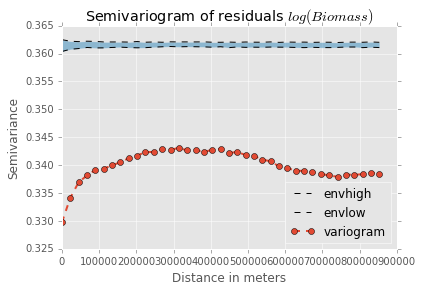

In [4]:
gvg.plot(refresh=False,legend=False,percentage_trunked=20)
plt.title("Semivariogram of residuals $log(Biomass) ~ log(SppR)$")



Now that the empirical variogram has been created we need to use a valid theoretical variogram model to fit it.
The models ares in *spystats.tools*

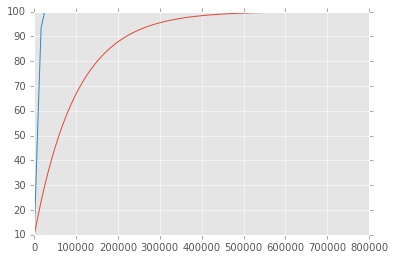

In [5]:
from external_plugins.spystats import tools
hx = np.linspace(0,800000,100)
expmod = tools.exponentialVariogram(hx,sill=100,nugget=10,range_a=100000)
gausmod = tools.gaussianVariogram(hx,sill=100,nugget=10,range_a=10000)
plt.plot(hx,expmod)
plt.plot(hx,gausmod)

## Fitting the model to the empirical variogram
It´s included as a method from the Variogram

In [6]:
matern,cs = gvg.fitTheoreticalVariogramModel(tools.maternVariogram,[0.34,500000,0.33,0.5])
expm,cs2 = gvg.fitTheoreticalVariogramModel(tools.exponentialVariogram,[0.34,500000,0.33])
gausm,cs3 = gvg.fitTheoreticalVariogramModel(tools.gaussianVariogram,[0.34,500000,0.33])
sphm,cs4  = gvg.fitTheoreticalVariogramModel(tools.sphericalVariogram,[0.34,500000,0.33])

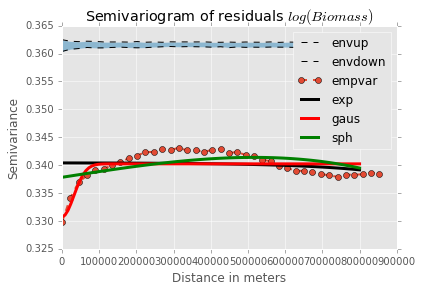

In [15]:
gvg.plot(refresh=False,legend=False,percentage_trunked=20)
plt.title("Semivariogram of residuals $log(Biomass) ~ log(SppR)$")
#plt.plot(hx,matern(hx))
plt.plot(hx,expm(hx),lw=3,c='black')
plt.plot(hx,gausm(hx),lw=3,c='red')
plt.plot(hx,sphm(hx),lw=3,c='green')
plt.legend(['envup','envdown','empvar','exp','gaus','sph'])


## Let´s check if the methods in the class VariogramModel works

In [9]:
matm = tools.MaternVariogram(sill=0.34,range_a=500000,nugget=0.33,kappa=0.5)
expmm = tools.ExponentialVariogram(sill=0.34,range_a=500000,nugget=0.33)
gausms = tools.GaussianVariogram(sill=0.34,range_a=500000,nugget=0.33)
sphmm = tools.SphericalVariogram(sill=0.34,range_a=500000,nugget=0.33)
map(lambda l : l.fit(gvg), [matm,expmm,gausms,sphmm])

print(matm)
print(expmm)
print(gausms)
print(sphmm)

< Matern Variogram : sill -0.113569688811, range 2993343.4414, nugget 0.271487768538, kappa 2.43372927036 >
< Exponential Variogram : sill 0.340414866589, range -200881.06732, nugget 0.340391321257 >
< Gaussian Variogram : sill 0.340223068359, range -44965.6248235, nugget 0.330727856723 >
< Spherical Variogram : sill 266987965076.0, range 3.86443289284e+19, nugget 0.337812915521 >


In [12]:
## Compare with the other method
print(cs['parameters'])
print(cs2['parameters'])
print(cs3['parameters'])
print(cs4['parameters'])

[ -1.13569689e-01   2.99334344e+06   2.71487769e-01   2.43372927e+00]
[  3.40414867e-01  -2.00881067e+05   3.40391321e-01]
[  3.40223068e-01  -4.49656248e+04   3.30727857e-01]
[  2.66987965e+11   3.86443289e+19   3.37812916e-01]


In [13]:
### need to do correlation function